# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [40]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False,analyzer='word',stop_words='english')
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [41]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=50)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [42]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/skyladfah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 10022, 'Neg': 9978, 'TP': 5708, 'TN': 4276, 'FP': 5702, 'FN': 4314, 'Accuracy': 0.4992, 'Precision': 0.5002629272567923, 'Recall': 0.5695469966074636, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [43]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train_original')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train_original'}


In [61]:
from sklearn import linear_model
svm1 = linear_model.SGDClassifier(alpha=0.0001)
svm1.fit(X_train, y_train)

svm1_performance_train = BinaryClassificationPerformance(svm1.predict(X_train), y_train, 'alpha_0.0001')
svm1_performance_train.compute_measures()
print(svm1_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'alpha_0.0001'}


In [45]:
from sklearn import linear_model
svm2 = linear_model.SGDClassifier(alpha=1.0)
svm2.fit(X_train, y_train)

svm2_performance_train = BinaryClassificationPerformance(svm2.predict(X_train), y_train, 'alpha_1.0')
svm2_performance_train.compute_measures()
print(svm2_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 9999, 'TN': 9957, 'FP': 21, 'FN': 23, 'Accuracy': 0.9978, 'Precision': 0.9979041916167665, 'Recall': 0.9977050488924366, 'desc': 'alpha_1.0'}


In [46]:
from sklearn import linear_model
svm3 = linear_model.SGDClassifier(alpha=5.0)
svm3.fit(X_train, y_train)

svm3_performance_train = BinaryClassificationPerformance(svm3.predict(X_train), y_train, 'alpha_5.0')
svm3_performance_train.compute_measures()
print(svm3_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 9851, 'TN': 9848, 'FP': 130, 'FN': 171, 'Accuracy': 0.98495, 'Precision': 0.9869752529806632, 'Recall': 0.9829375374176811, 'desc': 'alpha_5.0'}


In [51]:
from sklearn import linear_model
svm4 = linear_model.SGDClassifier(alpha=100.0)
svm4.fit(X_train, y_train)

svm4_performance_train = BinaryClassificationPerformance(svm4.predict(X_train), y_train, 'alpha_100.0')
svm4_performance_train.compute_measures()
print(svm4_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 9423, 'TN': 9667, 'FP': 311, 'FN': 599, 'Accuracy': 0.9545, 'Precision': 0.9680501335524964, 'Recall': 0.9402314907204151, 'desc': 'alpha_100.0'}


In [52]:
from sklearn import linear_model
svm5 = linear_model.SGDClassifier(alpha=50.0)
svm5.fit(X_train, y_train)

svm5_performance_train = BinaryClassificationPerformance(svm5.predict(X_train), y_train, 'alpha_50.0')
svm5_performance_train.compute_measures()
print(svm5_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 9391, 'TN': 9689, 'FP': 289, 'FN': 631, 'Accuracy': 0.954, 'Precision': 0.9701446280991736, 'Recall': 0.9370385152664139, 'desc': 'alpha_50.0'}


### MODEL: logistic regression

In [53]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [54]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 9741, 'TN': 9863, 'FP': 115, 'FN': 281, 'Accuracy': 0.9802, 'Precision': 0.9883319805194806, 'Recall': 0.971961684294552, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [55]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [56]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 10022, 'TN': 9978, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10022, 'Neg': 9978, 'TP': 8555, 'TN': 5927, 'FP': 4051, 'FN': 1467, 'Accuracy': 0.7241, 'Precision': 0.678645089639854, 'Recall': 0.8536220315306327, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

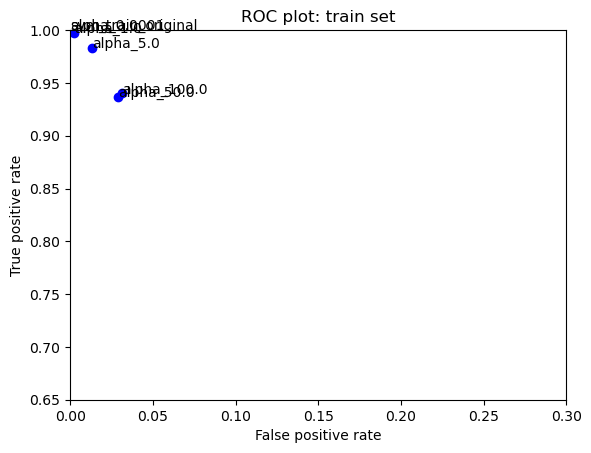

In [102]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits = [svm_performance_train,svm1_performance_train,svm2_performance_train,svm3_performance_train, svm4_performance_train,svm5_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.3, 0.65, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [74]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [75]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
94
with a title like this, you know not to expect a great horror movie. But this was really bad, even with low expectations. The plot is really insulting and stupid: an escaped criminal wears a Halloween mask, so everyone around him thinks he's someone else. this joke might actually work for 5 or 10 minutes, but not during the entire movie ! the actors are not that bad, but their characters are rather dumb and the story is boring and downright stupid. No suspense, no excitement and little gore (very cheap). Satan's Little Helper tries to combine horror (...) with comedy and fails dramatically at that. It became so boring towards the end, that I actually stopped watching 10 minutes before the end. I couldn't care whatever happened. Amanda Plummer was great in Pulp Fiction, but come on.. that was 13 years ago, and she hasn't done anything decent after that. So no wonder that she had to sink as low as this piece of crap.. Avoid or be warned..
* * * * * * * * *

7625
Even if you subscribe to the knee-jerk anti-free-trade politics of this movie, it is still just the same tired note, played again and again and again. Clink clink clink. Even if you can accept a preacher with peroxide hair who advocates a return to first principles, the Reverend Billy is pretty hard to look at as a serious figure. The clownish reverend is the sort who wakes every morning with no aspiration more ethereal than to see his own face on TV before he climbs back into bed that night. He has a pretty wife, I have to admit, but it would take tons more than that to save this dreary mess of a movie. The interminable bus rides are the worst part--with progress shown--can you guess?--by a colored line moving across a map. Aww, you guessed. Oh well, it has the virtue of being short. Is that the only favorable thing I can say? Hmmmm. Yep, afraid so.
* * * * * * * * * 
7742
Peter Sellers (one of my favorite actors) is mildly amusing in this 1970 turkey, but the script is so lame a

14128
I went in expecting the movie to be completely dumb. With such a low expectation, any form of entertainment would be a pleasant surprise. The soundtrack was the best part of the movie, but poking fun at the nonsense that goes on in singles wards was also amusing.<br /><br />This said, there were many things about The Singles Ward that were completely annoying. The entire film was poorly dubbed and made watching mouths while listening to their voices very irritating. This lack of professionalism was surpassed only by the cameos of Mormon celebrities who have no business acting.<br /><br />This film will do well among Mormondom, especially in college communities where singles ward exist. However the conclusion will offer no hope for the poor losers who find themselves unmarried. (Only the pretty girls in the Singles Ward get married, the fat, ugly ones don't, but all the ugly men do) Ultimately we realize that the whole film was an advertisement for LDSSingles.com
* * * * * * * * *

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [76]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1487, 'TN': 976, 'FP': 1546, 'FN': 991, 'Accuracy': 0.4926, 'Precision': 0.49027365644576326, 'Recall': 0.6000807102502018, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [84]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_original')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2057, 'TN': 2070, 'FP': 452, 'FN': 421, 'Accuracy': 0.8254, 'Precision': 0.8198485452371462, 'Recall': 0.8301049233252623, 'desc': 'svm_original'}


In [85]:
svm1_performance_test = BinaryClassificationPerformance(svm1.predict(X_test), y_test, 'alpha_0.0001')
svm1_performance_test.compute_measures()
print(svm1_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2029, 'TN': 2091, 'FP': 431, 'FN': 449, 'Accuracy': 0.824, 'Precision': 0.8247967479674797, 'Recall': 0.8188054882970137, 'desc': 'alpha_0.0001'}


In [86]:
svm2_performance_test = BinaryClassificationPerformance(svm2.predict(X_test), y_test, 'alpha_1.0')
svm2_performance_test.compute_measures()
print(svm2_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2193, 'TN': 2161, 'FP': 361, 'FN': 285, 'Accuracy': 0.8708, 'Precision': 0.8586530931871574, 'Recall': 0.8849878934624698, 'desc': 'alpha_1.0'}


In [87]:
svm3_performance_test = BinaryClassificationPerformance(svm3.predict(X_test), y_test, 'alpha_5.0')
svm3_performance_test.compute_measures()
print(svm3_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2203, 'TN': 2205, 'FP': 317, 'FN': 275, 'Accuracy': 0.8816, 'Precision': 0.8742063492063492, 'Recall': 0.8890234059725585, 'desc': 'alpha_5.0'}


In [88]:
svm4_performance_test = BinaryClassificationPerformance(svm4.predict(X_test), y_test, 'alpha_100.0')
svm4_performance_test.compute_measures()
print(svm4_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2116, 'TN': 2175, 'FP': 347, 'FN': 362, 'Accuracy': 0.8582, 'Precision': 0.8591149005278116, 'Recall': 0.8539144471347861, 'desc': 'alpha_100.0'}


In [89]:
svm5_performance_test = BinaryClassificationPerformance(svm5.predict(X_test), y_test, 'alpha_50.0')
svm5_performance_test.compute_measures()
print(svm5_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2095, 'TN': 2192, 'FP': 330, 'FN': 383, 'Accuracy': 0.8574, 'Precision': 0.8639175257731959, 'Recall': 0.8454398708635997, 'desc': 'alpha_50.0'}


### MODEL: logistic regression

In [90]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2031, 'TN': 2072, 'FP': 450, 'FN': 447, 'Accuracy': 0.8206, 'Precision': 0.8186215235792019, 'Recall': 0.8196125907990315, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [91]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 1854, 'TN': 1903, 'FP': 619, 'FN': 624, 'Accuracy': 0.7514, 'Precision': 0.7496967246259604, 'Recall': 0.7481840193704601, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [92]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2035, 'TN': 2056, 'FP': 466, 'FN': 443, 'Accuracy': 0.8182, 'Precision': 0.8136745301879248, 'Recall': 0.821226795803067, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2196, 'TN': 2099, 'FP': 423, 'FN': 282, 'Accuracy': 0.859, 'Precision': 0.8384879725085911, 'Recall': 0.8861985472154964, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2478, 'Neg': 2522, 'TP': 2127, 'TN': 1409, 'FP': 1113, 'FN': 351, 'Accuracy': 0.7072, 'Precision': 0.6564814814814814, 'Recall': 0.8583535108958837, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

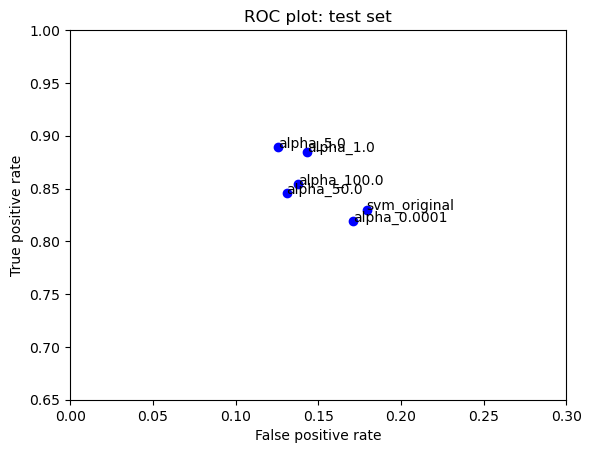

In [101]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits = [svm_performance_test,svm1_performance_test,svm2_performance_test,svm3_performance_test,svm4_performance_test,svm5_performance_test]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.3, 0.65, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation